Hunter Bennett | Glass Lab | 15 June 2021

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import pearsonr # for correlation

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import import_homer_diffgene, read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [3]:
atacDirectory = '/home/h1bennet/strains/data/ATAC/control_f1/'
h3k27acDirectory = '/home/h1bennet/strains/data/H3K27Ac/control_f1/'
workingDirectory = '/home/h1bennet/strains_f1/results/01_CB6F1_MultiOmic/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [4]:
atac_balb = np.sort(glob.glob(atacDirectory+'/*only_muts*balbcj*'))
atac_c57 = np.sort(glob.glob(atacDirectory+'/*only_muts*mm10*'))
h3k27ac_balb = np.sort(glob.glob(h3k27acDirectory+'/*only_muts*balbcj*'))
h3k27ac_c57 = np.sort(glob.glob(h3k27acDirectory+'/*only_muts*mm10*'))

tagdirs = list(atac_balb) + list(atac_c57) + list(h3k27ac_balb) + list(h3k27ac_c57)

In [5]:
with open('./annotatePromoters_homer_new.sh', 'w') as f:
    annotate_prom = ['annotatePeaks.pl', 'tss', 'mm10', '-d \\\n',
                       ' \\\n'.join(tagdirs), '>',
                       './mm10_promoters_f1_atac_h3k27ac_new.txt &\n\n']

    
    f.write(' '.join(annotate_prom))    
    
    f.close()

In [6]:
with open('./annotatePromoters_homer_pc3.sh', 'w') as f:
    annotate_prom = ['annotatePeaks.pl', 'tss', 'mm10', '-pc 3', '-d \\\n',
                       ' \\\n'.join(tagdirs), '>',
                       './mm10_promoters_f1_atac_h3k27ac_pc3.txt &\n\n']

    
    f.write(' '.join(annotate_prom))    
    
    f.close()

# read in annotated peaks

In [7]:
df = pd.read_csv('./mm10_promoters_f1_atac_h3k27ac_onlymuts.txt',
                 sep='\t', index_col=0)
df.index = df.index.rename('RefseqID')
df = df.reset_index().set_index('Gene Name')

df_mat = df.loc[:, df.columns.str.contains('Tag Count in given bp')]
# clean columns
df_mat.columns = df_mat.columns.str.split('/').str[-1]

## Filter low tag promoters
For some reason nan are showing up here... should figure out eventually

In [8]:
greps = ['ATAC.*mm10',
         'ATAC.*balbcj']

colnames = ['c57bl6j_atac_average',
            'balbcj_atac_average']

# extract passing peak set
thresh = 8
n_passing_thresh = 3
thresh_passing_peaks = []
avg_tags_dict = {}
for colname, grep in zip(colnames, greps):
    print(colname)
    print(df_mat.loc[:, (df_mat.columns.str.contains(grep))].columns)
    bool_peaks = (df_mat.loc[:, (df_mat.columns.str.contains(grep))] > thresh).sum(1)>n_passing_thresh
    thresh_passing_peaks.extend(df_mat.index[bool_peaks].tolist())
atac_passing_peaks = set(thresh_passing_peaks)

print("N IDR Peaks:", df_mat.shape[0])
print("N Peaks Passing Thresh:", len(set(thresh_passing_peaks)))

for colname, grep in zip(colnames, greps):
    avg_tags_dict[colname] = df_mat.loc[atac_passing_peaks, df_mat.columns.str.contains(grep)].mean(1)
    
avg_tags_df_atac = pd.DataFrame(avg_tags_dict)

c57bl6j_atac_average
Index(['tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61A_TDT_l20210213_CTAGTACG_TCGACTAG_S7_L001_trim30.mm10.bowtie2.sam Tag Count in given bp (2285795.0 Total, normalization factor = 4.37, effective total = 10000000)',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61B_TDT_l20210213_TTCTGCCT_TTCTAGCT_S8_L001_trim30.mm10.bowtie2.sam Tag Count in given bp (1494908.0 Total, normalization factor = 6.69, effective total = 10000000)',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61C_TDT_l20210213_GCTCAGGA_CCTAGAGT_S9_L001_trim30.mm10.bowtie2.sam Tag Count in given bp (1665214.5 Total, normalization factor = 6.01, effective total = 10000000)',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61D_TDT_l20210213_AGGAGTCC_GCGTAAGA_S10_L001_trim30.mm10.bowtie2.sam Tag Count in given bp (1826844.5 Total, normalization factor = 5.47, effective total = 10000000)'],
      dtype='object')

In [9]:
greps = [# 'tag_perfect.*mm10',
         # 'tag_perfect.*balbcj',
         'H3K27.*mm10',
         'H3K27.*balbcj']

colnames = ['c57bl6j_h3k27ac_average',
            'balbcj_h3k27ac_average']

thresh = 8
n_passing_thresh = 2
thresh_passing_peaks = []
avg_tags_dict = {}
for colname, grep in zip(colnames, greps):
    print(colname)
    print(df_mat.loc[:, (df_mat.columns.str.contains(grep))].columns)
    bool_peaks = (df_mat.loc[:, (df_mat.columns.str.contains(grep))] > thresh).sum(1)>n_passing_thresh
    thresh_passing_peaks.extend(df_mat.index[bool_peaks].tolist())
    
h3k27ac_passing_peaks = set(thresh_passing_peaks)

print("N IDR Peaks:", df_mat.shape[0])
print("N Peaks Passing Thresh:", len(set(thresh_passing_peaks)))

for colname, grep in zip(colnames, greps):
    avg_tags_dict[colname] = df_mat.loc[h3k27ac_passing_peaks, df_mat.columns.str.contains(grep)].mean(1)
    
avg_tags_df_h3k27ac = pd.DataFrame(avg_tags_dict)

c57bl6j_h3k27ac_average
Index(['tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61A_TDT_l20201212_AGTTCAGG_CCAACAGA_S23_L001.mm10.bowtie2.sam Tag Count in given bp (2042827.5 Total, normalization factor = 4.90, effective total = 10000000)',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61BC_TDT_l20201212_GACCTGAA_TTGGTGAG_S24_L001.mm10.bowtie2.sam Tag Count in given bp (2801089.5 Total, normalization factor = 3.57, effective total = 10000000)',
       'tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61D_TDT_l20201212_TCTCTACT_CGCGGTTC_S25_L001.mm10.bowtie2.sam Tag Count in given bp (2204889.0 Total, normalization factor = 4.54, effective total = 10000000)'],
      dtype='object')
balbcj_h3k27ac_average
Index(['tag_only_muts_mouse_cb6f1j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_CB61A_TDT_l20201212_AGTTCAGG_CCAACAGA_S23_L001.balbcj.bowtie2_shifted_from_BALBCJ.sam Tag Count in given bp (1946407.0 Total, no

## Extract average expression values

In [10]:
greps = ['ATAC.*balbc.*',
         'ATAC.*mm10.*',
         'H3K27.*balbc.*',
         'H3K27.*mm10.*']

colnames = ['balbcj_atac_average',
            'c57bl6j_atac_average',
            'balbcj_h3k27ac_average',
            'c57bl6j_h3k27ac_average']


### Filter duplicates

In [11]:
avg_tags_df_atac.loc[:, 'mean_tags'] = avg_tags_df_atac.mean(1)
avg_tags_df_atac = avg_tags_df_atac.sort_values('mean_tags', ascending=False).reset_index()
avg_tags_df_atac = avg_tags_df_atac.drop_duplicates(subset='Gene Name',
                                                    keep='first')
avg_tags_df_atac = avg_tags_df_atac.drop(columns='mean_tags')


avg_tags_df_atac = avg_tags_df_atac.set_index('Gene Name')

In [12]:
avg_tags_df_h3k27ac.loc[:, 'mean_tags'] = avg_tags_df_h3k27ac.mean(1)
avg_tags_df_h3k27ac = avg_tags_df_h3k27ac.sort_values('mean_tags', ascending=False).reset_index()
avg_tags_df_h3k27ac = avg_tags_df_h3k27ac.drop_duplicates(subset='Gene Name',
                                                    keep='first')
avg_tags_df_h3k27ac = avg_tags_df_h3k27ac.drop(columns='mean_tags')

avg_tags_df_h3k27ac = avg_tags_df_h3k27ac.set_index('Gene Name')

In [13]:
tpm_mat = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferF1/rnaQuan/rawT.txt',
                      sep='\t', index_col=0)
tpm_mat = tpm_mat.loc[:, tpm_mat.columns.str.contains('variants')]

# clean columns
tpm_mat.columns = tpm_mat.columns.str.split('/').str[-1]

### Extract average

In [14]:
groups = ['balbcj_variants',
          'c57bl6j_variants']

In [15]:
thresh = 4
n_passing_thresh = 3
thresh_passing_genes = []
avg_tpm_dict = {}
for group in groups:
    # print(df_mat.loc[:, (df_mat.columns.str.contains(grep))].columns)
    bool_peaks = (tpm_mat.loc[:, (tpm_mat.columns.str.contains(group))] > thresh).sum(1)>n_passing_thresh
    thresh_passing_genes.extend(tpm_mat.index[bool_peaks].tolist())


print("N Genes:", tpm_mat.shape[0])
print("N Genes Passing Thresh:", len(set(thresh_passing_genes)))


for group in groups:
    avg = tpm_mat.loc[set(thresh_passing_genes), tpm_mat.columns.str.contains(group)].mean(1)
    avg_tpm_dict[group] = avg
    
avg_tpm_df = pd.DataFrame(avg_tpm_dict)

N Genes: 23608
N Genes Passing Thresh: 3899


# Calculate allelic fraction in all dfs

In [16]:
avg_tags_df_atac['balbcj_h3k27_allelic_fraction'] = avg_tags_df_atac.balbcj_atac_average / avg_tags_df_atac.sum(1)
avg_tags_df_h3k27ac['balbcj_atac_allelic_fraction'] = avg_tags_df_h3k27ac.balbcj_h3k27ac_average / avg_tags_df_h3k27ac.sum(1)
avg_tpm_df['balbcj_rna_allelic_fraction'] = avg_tpm_df.balbcj_variants / avg_tpm_df.sum(1)

## calculate log2fc

In [17]:
avg_tags_df_atac['balbcj_atac_log2fc'] = np.log2(avg_tags_df_atac.balbcj_atac_average / avg_tags_df_atac.c57bl6j_atac_average)
avg_tags_df_h3k27ac['balbcj_h3k27_log2fc'] = np.log2(avg_tags_df_h3k27ac.balbcj_h3k27ac_average / avg_tags_df_h3k27ac.c57bl6j_h3k27ac_average)
avg_tpm_df['balbcj_rna_log2fc'] = np.log2(avg_tpm_df.balbcj_variants / avg_tpm_df.c57bl6j_variants)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Make H3K27Ac and RNA DF

In [18]:
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

In [19]:
h3k27_rna_df = avg_tpm_df.merge(avg_tags_df_h3k27ac, how='inner',
                                left_index=True, right_index=True)
# filter infinite values
h3k27_rna_df.replace([np.inf, -np.inf], np.nan, inplace=True)
h3k27_rna_df.dropna(inplace=True)

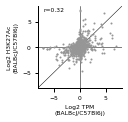

In [20]:
fig, ax = plt.subplots(figsize=(1.5,1.5))

ax.plot([-10,10],[-10,10],
        c='k',
        linewidth=0.5,
        zorder=0)
ax.axhline(0, c='k', linewidth=0.5, zorder=0)
ax.axvline(0, c='k', linewidth=0.5, zorder=0)

ax.scatter(h3k27_rna_df.balbcj_rna_log2fc,
           h3k27_rna_df.balbcj_h3k27_log2fc,
           s=1,
           c='#969696',
           zorder=1)
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])
ax.set_xlabel('Log2 TPM\n(BALBcJ/C57Bl6j)')
ax.set_ylabel('Log2 H3K27Ac\n(BALBcJ/C57Bl6j)')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# calculate pearson r
r, pval = pearsonr(h3k27_rna_df.balbcj_rna_log2fc,
                   h3k27_rna_df.balbcj_h3k27_log2fc)

#annotate pearson r
ax.text(-7, 7, 'r=%.2f' % r);

plt.savefig('./figures/rna_h3k27ac_asb_scatter.png',
            bbox_inches='tight')

In [21]:
atac_rna_df = avg_tpm_df.merge(avg_tags_df_atac, how='inner',
                                left_index=True, right_index=True)

# filter infinite values
atac_rna_df.replace([np.inf, -np.inf], np.nan, inplace=True)
atac_rna_df.dropna(inplace=True)

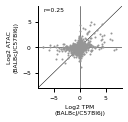

In [22]:
fig, ax = plt.subplots(figsize=(1.5,1.5))

ax.plot([-10,10],[-10,10],
        c='k',
        linewidth=0.5,
        zorder=0)
ax.axhline(0, c='k', linewidth=0.5, zorder=0)
ax.axvline(0, c='k', linewidth=0.5, zorder=0)

ax.scatter(atac_rna_df.balbcj_rna_log2fc,
           atac_rna_df.balbcj_atac_log2fc,
           s=1,
           c='#969696',
           zorder=1)
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])
ax.set_xlabel('Log2 TPM\n(BALBcJ/C57Bl6j)')
ax.set_ylabel('Log2 ATAC\n(BALBcJ/C57Bl6j)')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# calculate pearson r
r, pval = pearsonr(atac_rna_df.balbcj_rna_log2fc,
                   atac_rna_df.balbcj_atac_log2fc)

#annotate pearson r
ax.text(-7, 7, 'r=%.2f' % r);

plt.savefig('./figures/rna_atac_asb_scatter.png',
            bbox_inches='tight')

In [32]:
atac_h3k27ac_df = avg_tags_df_atac.merge(avg_tags_df_h3k27ac, how='inner',
                                         left_index=True, right_index=True)

# filter infinite values
atac_h3k27ac_df.replace([np.inf, -np.inf], np.nan, inplace=True)
atac_h3k27ac_df.dropna(inplace=True)

In [33]:
atac_h3k27ac_df.columns

Index(['c57bl6j_atac_average', 'balbcj_atac_average',
       'balbcj_h3k27_allelic_fraction', 'balbcj_atac_log2fc',
       'c57bl6j_h3k27ac_average', 'balbcj_h3k27ac_average',
       'balbcj_atac_allelic_fraction', 'balbcj_h3k27_log2fc'],
      dtype='object')

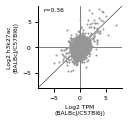

In [35]:
fig, ax = plt.subplots(figsize=(1.5,1.5))

ax.plot([-10,10],[-10,10],
        c='k',
        linewidth=0.5,
        zorder=0)
ax.axhline(0, c='k', linewidth=0.5, zorder=0)
ax.axvline(0, c='k', linewidth=0.5, zorder=0)

ax.scatter(atac_h3k27ac_df.balbcj_atac_log2fc,
           atac_h3k27ac_df.balbcj_h3k27_log2fc,
           s=1,
           c='#969696',
           zorder=1)
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])
ax.set_xlabel('Log2 TPM\n(BALBcJ/C57Bl6j)')
ax.set_ylabel('Log2 h3k27ac\n(BALBcJ/C57Bl6j)')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# calculate pearson r
r, pval = pearsonr(atac_h3k27ac_df.balbcj_atac_log2fc,
                   atac_h3k27ac_df.balbcj_h3k27_log2fc)

#annotate pearson r
ax.text(-7, 7, 'r=%.2f' % r);

plt.savefig('./figures/atac_h3k27ac_asb_scatter.png',
            bbox_inches='tight')

# color by biased promoter

In [23]:
diffDir = '/home/ttroutman/strainsKupffer/rnaKupfferF1/rnaDiff/'
rnaQuan = '/home/ttroutman/strainsKupffer/rnaKupfferF1/rnaQuan/rawT.txt'


In [24]:
diff_gene_control, tpm_control, tpm_mat_control, tpm_mat_quant_control = import_homer_diffgene(
    diffDir+'/balbcj_control.vs.c57bl6j_control.scatter.txt',
    rnaQuan)


ge all transcripts (23608, 20)
Diff Gene selected transcripts (7667, 7)
ge selected transcripts (7667, 20)


In [25]:
color_dict = {'nonsig':'#636363',
              'c57':'#31a354',
              'balb':'#3182bd'}
log2fc = np.log2(2)
padj = 0.05

In [26]:
colors = []
for gene in h3k27_rna_df.index.tolist():
    try:
        if ((diff_gene_control.loc[gene, 'log2FoldChange'] <= -log2fc) & (diff_gene_control.loc[gene, 'padj'] < 0.05)):
            colors.append(color_dict['balb'])
        elif ((diff_gene_control.loc[gene, 'log2FoldChange'] >= log2fc) & (diff_gene_control.loc[gene, 'padj'] < 0.05)):
            colors.append(color_dict['c57'])
        else:
            colors.append(color_dict['nonsig'])
    except KeyError:
        colors.append(color_dict['nonsig'])

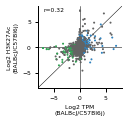

In [27]:
fig, ax = plt.subplots(figsize=(1.5,1.5))

ax.plot([-10,10],[-10,10],
        c='k',
        linewidth=0.5,
        zorder=0)
ax.axhline(0, c='k', linewidth=0.5, zorder=0)
ax.axvline(0, c='k', linewidth=0.5, zorder=0)

ax.scatter(h3k27_rna_df.balbcj_rna_log2fc,
           h3k27_rna_df.balbcj_h3k27_log2fc,
           s=1,
           c=colors,
           zorder=1)
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])
ax.set_xlabel('Log2 TPM\n(BALBcJ/C57Bl6j)')
ax.set_ylabel('Log2 H3K27Ac\n(BALBcJ/C57Bl6j)')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# calculate pearson r
r, pval = pearsonr(h3k27_rna_df.balbcj_rna_log2fc,
                   h3k27_rna_df.balbcj_h3k27_log2fc)

#annotate pearson r
ax.text(-7, 7, 'r=%.2f' % r, fontsize=6);

plt.savefig('./figures/rna_h3k27ac_asb_scatter_color_diff_prom.pdf',
            bbox_inches='tight')

In [28]:
colors = []
for gene in atac_rna_df.index.tolist():
    try:
        if ((diff_gene_control.loc[gene, 'log2FoldChange'] <= -log2fc) & (diff_gene_control.loc[gene, 'padj'] < 0.05)):
            colors.append(color_dict['balb'])
        elif ((diff_gene_control.loc[gene, 'log2FoldChange'] >= log2fc) & (diff_gene_control.loc[gene, 'padj'] < 0.05)):
            colors.append(color_dict['c57'])
        else:
            colors.append(color_dict['nonsig'])
    except KeyError:
        colors.append(color_dict['nonsig'])

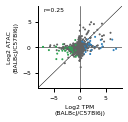

In [29]:
fig, ax = plt.subplots(figsize=(1.5,1.5))

ax.plot([-10,10],[-10,10],
        c='k',
        linewidth=0.5,
        zorder=0)
ax.axhline(0, c='k', linewidth=0.5, zorder=0)
ax.axvline(0, c='k', linewidth=0.5, zorder=0)

ax.scatter(atac_rna_df.balbcj_rna_log2fc,
           atac_rna_df.balbcj_atac_log2fc,
           s=1,
           c=colors,
           zorder=1)
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])
ax.set_xlabel('Log2 TPM\n(BALBcJ/C57Bl6j)')
ax.set_ylabel('Log2 ATAC\n(BALBcJ/C57Bl6j)')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# calculate pearson r
r, pval = pearsonr(atac_rna_df.balbcj_rna_log2fc,
                   atac_rna_df.balbcj_atac_log2fc)

#annotate pearson r
ax.text(-7, 7, 'r=%.2f' % r);

plt.savefig('./figures/rna_atac_asb_scatter_color_diff_prom.pdf',
            bbox_inches='tight')

In [37]:
colors = []
for gene in atac_h3k27ac_df.index.tolist():
    try:
        if ((diff_gene_control.loc[gene, 'log2FoldChange'] <= -log2fc) & (diff_gene_control.loc[gene, 'padj'] < 0.05)):
            colors.append(color_dict['balb'])
        elif ((diff_gene_control.loc[gene, 'log2FoldChange'] >= log2fc) & (diff_gene_control.loc[gene, 'padj'] < 0.05)):
            colors.append(color_dict['c57'])
        else:
            colors.append(color_dict['nonsig'])
    except KeyError:
        colors.append(color_dict['nonsig'])

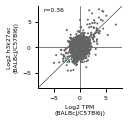

In [39]:
fig, ax = plt.subplots(figsize=(1.5,1.5))

ax.plot([-10,10],[-10,10],
        c='k',
        linewidth=0.5,
        zorder=0)
ax.axhline(0, c='k', linewidth=0.5, zorder=0)
ax.axvline(0, c='k', linewidth=0.5, zorder=0)

ax.scatter(atac_h3k27ac_df.balbcj_atac_log2fc,
           atac_h3k27ac_df.balbcj_h3k27_log2fc,
           s=1,
           c=colors,
           zorder=1)
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])
ax.set_xlabel('Log2 TPM\n(BALBcJ/C57Bl6j)')
ax.set_ylabel('Log2 h3k27ac\n(BALBcJ/C57Bl6j)')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# calculate pearson r
r, pval = pearsonr(atac_h3k27ac_df.balbcj_atac_log2fc,
                   atac_h3k27ac_df.balbcj_h3k27_log2fc)

#annotate pearson r
ax.text(-7, 7, 'r=%.2f' % r);

plt.savefig('./figures/atac_h3k27ac_asb_scatter_color_diff_prom.pdf',
            bbox_inches='tight')